In [89]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [90]:
''' removing any unnecessary warnings ''' 

import warnings
from matplotlib import MatplotlibDeprecationWarning

# Suppress only specific font glyph warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from font.*")

# Optionally suppress Matplotlib deprecation warnings (if they become noisy)
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

In [91]:
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
MONTHS = ["apr23", "may23", "jun23", "jul23", "aug23", "sep23", "oct23", "nov23", "dec23", "jan24", "feb24", "mar24", "apr24", "may24", "jun24",  "jul24", "aug24"]  


### Loading data for all months & checking the amount of data for each token 

In [92]:
monthly_token_data = {}

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    month_prices = {}
    month_volumes = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue

            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            month_prices[token] = df[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
            month_volumes[token] = df[['days_since_launch', 'volume']].set_index('days_since_launch').rename(columns={'volume': token})
        except Exception as e:
            print(f"⚠️ Error in {token}: {e}")

    if month_prices and month_volumes:
        aligned_prices = pd.concat(month_prices.values(), axis=1, join='inner')
        aligned_volumes = pd.concat(month_volumes.values(), axis=1, join='inner')

        monthly_token_data[month] = {
            "prices": aligned_prices,
            "volumes": aligned_volumes
        }

        print(f"✅ Loaded {month}: {aligned_prices.shape[1]} tokens, {aligned_prices.shape[0]} days")
    else:
        print(f"❌ Skipped {month}: No valid token data found")


✅ Loaded apr23: 5 tokens, 60 days
✅ Loaded may23: 5 tokens, 18 days
✅ Loaded jun23: 5 tokens, 3 days
✅ Loaded jul23: 5 tokens, 60 days
✅ Loaded aug23: 5 tokens, 60 days
✅ Loaded sep23: 5 tokens, 60 days
✅ Loaded oct23: 5 tokens, 60 days
✅ Loaded nov23: 5 tokens, 60 days
✅ Loaded dec23: 5 tokens, 60 days
✅ Loaded jan24: 5 tokens, 60 days
✅ Loaded feb24: 5 tokens, 60 days
✅ Loaded mar24: 5 tokens, 60 days
✅ Loaded apr24: 5 tokens, 44 days
✅ Loaded may24: 5 tokens, 60 days
✅ Loaded jun24: 5 tokens, 60 days
✅ Loaded jul24: 5 tokens, 60 days
✅ Loaded aug24: 5 tokens, 60 days


### Calculating metrics for each month, indivisually

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in may24: ['MAGA', 'PEW', 'wQUIL', 'RETIK', 'EAI']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['MAGA', 'PEW', 'wQUIL', 'RETIK', 'EAI']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–60): ['MAGA', 'PEW', 'wQUIL', 'RETIK', 'EAI']


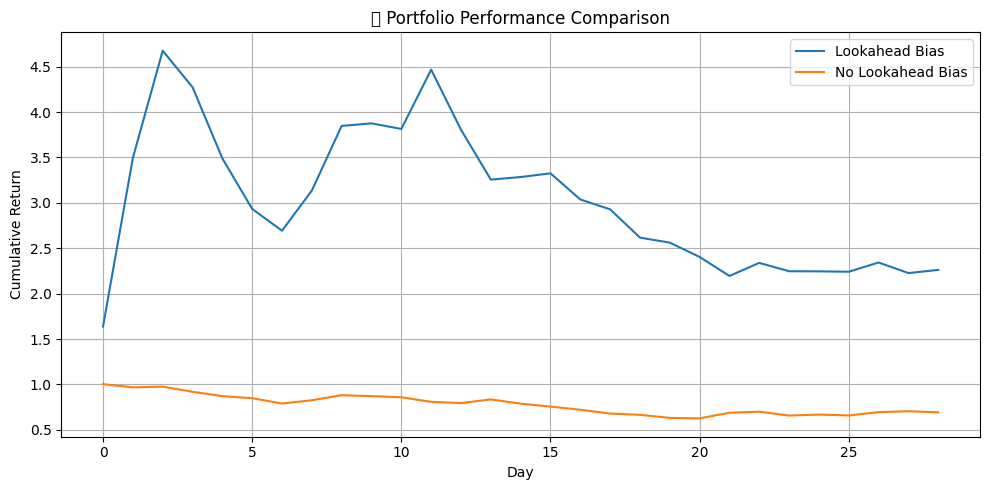


📊 Lookahead Bias Portfolio:
        Total Return: 126.17%
   Annualized Return: 2890715.12%
        Sharpe Ratio: 3.75
        Max Drawdown: -53.05%

📊 No Lookahead Bias Portfolio:
        Total Return: -30.70%
   Annualized Return: -99.01%
        Sharpe Ratio: -5.10
        Max Drawdown: -37.53%


In [93]:
# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 60
MONTH = "may24" 


# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")


# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")


# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")


# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics


# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")


# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


### Loop for Calculating metrics for ALL the months


📅 Processing month: apr23
✅ apr23: Return = -42.25%, Tokens Used = 5

📅 Processing month: may23
✅ may23: Return = 137.25%, Tokens Used = 4

📅 Processing month: jun23
✅ jun23: Return = 3.41%, Tokens Used = 4

📅 Processing month: jul23
✅ jul23: Return = -1.99%, Tokens Used = 5

📅 Processing month: aug23
✅ aug23: Return = -4.70%, Tokens Used = 5

📅 Processing month: sep23
✅ sep23: Return = 74.86%, Tokens Used = 5

📅 Processing month: oct23
✅ oct23: Return = 32.59%, Tokens Used = 5

📅 Processing month: nov23
✅ nov23: Return = -33.87%, Tokens Used = 5

📅 Processing month: dec23
✅ dec23: Return = 6.70%, Tokens Used = 5

📅 Processing month: jan24
✅ jan24: Return = 41.72%, Tokens Used = 5

📅 Processing month: feb24
✅ feb24: Return = -42.36%, Tokens Used = 5

📅 Processing month: mar24
✅ mar24: Return = 28.22%, Tokens Used = 5

📅 Processing month: apr24
✅ apr24: Return = 9.70%, Tokens Used = 5

📅 Processing month: may24
✅ may24: Return = -30.70%, Tokens Used = 5

📅 Processing month: jun24
✅ jun

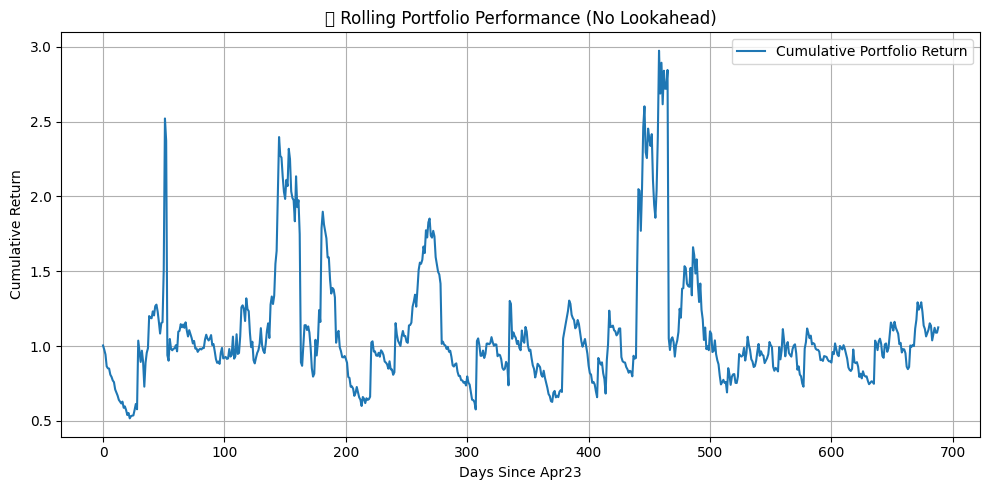

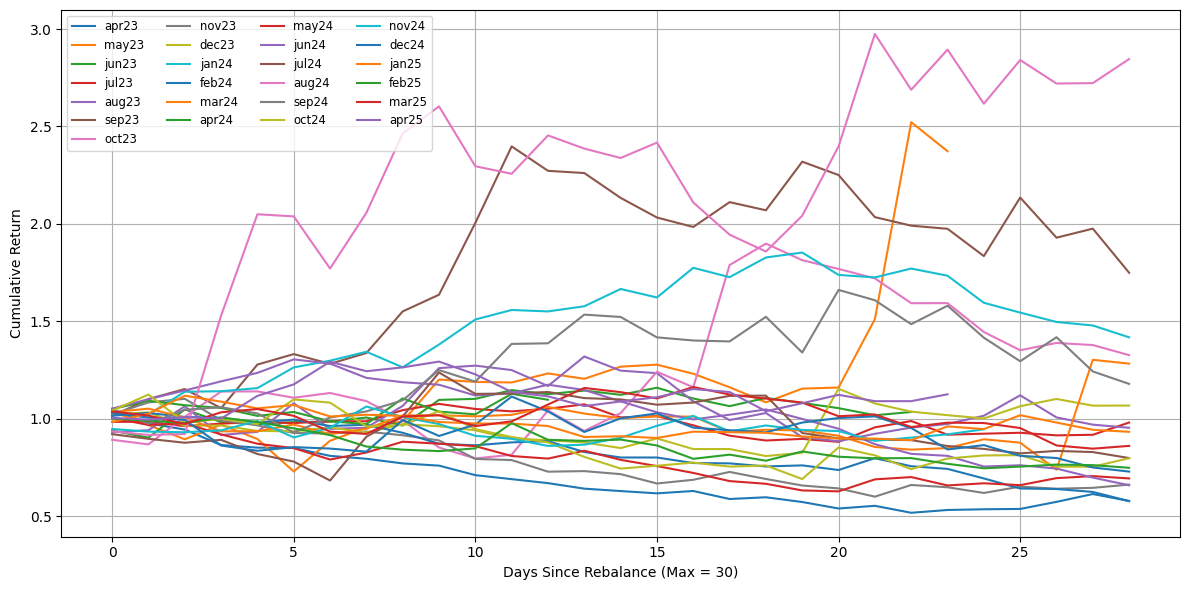


📊 Monthly No-Lookahead Performance Summary:
       Return (%)
Month            
apr23      -42.25
may23      137.25
jun23        3.41
jul23       -1.99
aug23       -4.70
sep23       74.86
oct23       32.59
nov23      -33.87
dec23        6.70
jan24       41.72
feb24      -42.36
mar24       28.22
apr24        9.70
may24      -30.70
jun24      -34.20
jul24      -20.23
aug24      184.59
sep24       17.83
oct24      -20.31
nov24       -5.49
dec24      -27.18
jan25       -6.76
feb25      -25.24
mar25      -13.99
apr25       12.49


In [94]:
# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 60
MONTHS = ["apr23", "may23", "jun23", "jul23", "aug23", "sep23", "oct23", "nov23", "dec23", 
          "jan24", "feb24", "mar24", "apr24", "may24", "jun24", "jul24", "aug24", "sep24", "oct24", "nov24", "dec24", "jan25", "feb25", "mar25", "apr25"]

monthly_returns = {}
all_cum_returns = []
cumulative_returns_per_month = {}

for month in MONTHS:
    print(f"\n📅 Processing month: {month}")
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    price_data = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns:
                continue
            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['day'] = df.index
            price_data[token] = df.set_index('day')['close']
        except Exception as e:
            print(f"❌ Error loading {token}: {e}")

    # Ensure we have exactly 5 tokens
    if len(price_data) != 5:
        print(f"⚠️ Skipping {month}: found {len(price_data)} tokens instead of 5.")
        continue

    # Slice day 30 to 60 for each token (keep whatever is available)
    prices = pd.DataFrame({
        t: s.loc[NO_LOOKAHEAD_START:NO_LOOKAHEAD_END] 
        for t, s in price_data.items()
    }).dropna(axis=1, how='all')  # drop tokens with all NaNs in that window

    if prices.shape[1] == 0:
        print("⚠️ No token has usable data in day 30–60 window.")
        continue

    # Calculate returns
    returns = prices.pct_change(fill_method=None).dropna()
    weights = np.ones(prices.shape[1]) / prices.shape[1]
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Save
    monthly_returns[month] = cum_returns.iloc[-1] - 1
    all_cum_returns.append(cum_returns)
    cumulative_returns_per_month[month] = cum_returns

    print(f"✅ {month}: Return = {monthly_returns[month]*100:.2f}%, Tokens Used = {prices.shape[1]}")


# === PLOT CUMULATIVE RETURNS ===
if all_cum_returns:
    joined = pd.concat(all_cum_returns, ignore_index=True)
    plt.figure(figsize=(10, 5))
    plt.plot(joined, label="Cumulative Portfolio Return")
    plt.title("📈 Rolling Portfolio Performance (No Lookahead)")
    plt.xlabel("Days Since Apr23")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    
# === PLOT MULTIPLE MONTHLY CURVES ===
if cumulative_returns_per_month:
    plt.figure(figsize=(12, 6))
    for month, cum_ret in cumulative_returns_per_month.items():
        plt.plot(cum_ret.values, label=month)
    # plt.title("zMonthly Rebalanced Portfolios - Cumulative Returns (Day 30–60)")
    plt.xlabel("Days Since Rebalance (Max = 30)")
    plt.ylabel("Cumulative Return")
    plt.legend(ncol=4, fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# === SUMMARY ===
summary_df = pd.DataFrame.from_dict(monthly_returns, orient='index', columns=["Return"])
summary_df.index.name = "Month"
summary_df["Return (%)"] = summary_df["Return"] * 100
print("\n📊 Monthly No-Lookahead Performance Summary:")
print(summary_df[["Return (%)"]].round(2))


#### - Total Returns Over ~24 months (Apr-23 to Apr-25)

In [95]:
# monthly return data
monthly_returns = [
    -42.25, 137.25, 3.41, -1.99, -4.70, 74.86, 32.59, -33.87, 6.70, 41.72,
    -42.36, 28.22, 9.70, -30.70, -34.20, -20.23, 184.59, 17.83, -20.31, -5.49,
    -27.18, -6.76, -25.24, -13.99, 12.49
]

# Convert to decimal form and calculate total return
returns = pd.Series(monthly_returns) / 100
total_return = (returns + 1).prod() - 1

month_list_len = len(MONTHS)
print(f"Total Portfolio Return over all the {month_list_len} months (compounded monthly): {total_return * 100:.2f}%")

''' === COMPARING EXCESS RETURNS OVER BTC & ETH === '''

# Load WBTC and ETH data
wbtc_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/bitcoin/WBTC.csv")
eth_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/ethereum/ETH.csv")

# Clean column names and parse dates
for df in [wbtc_df, eth_df]:
    df.columns = df.columns.str.lower()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') if df['timestamp'].dtype == 'int64' else pd.to_datetime(df['timestamp'])

# Sort the index after setting it
wbtc_df.set_index('timestamp', inplace=True)
wbtc_df = wbtc_df.sort_index()

eth_df.set_index('timestamp', inplace=True)
eth_df = eth_df.sort_index()

start_date = "2023-04-01"
end_date = "2025-04-30"

wbtc_prices = wbtc_df.loc[start_date:end_date]['close']
eth_prices = eth_df.loc[start_date:end_date]['close']

# Calculate total return for WBTC and ETH
wbtc_return = (wbtc_prices.iloc[-1] / wbtc_prices.iloc[0]) - 1
eth_return = (eth_prices.iloc[-1] / eth_prices.iloc[0]) - 1

portfolio_return = (returns + 1).prod() - 1

excess_over_wbtc = portfolio_return - wbtc_return
excess_over_eth = portfolio_return - eth_return

# print(f"📈 Portfolio Return: {portfolio_return * 100:.2f}%")
print(f"₿ WBTC Return:      {wbtc_return * 100:.2f}%")
print(f"Ξ ETH Return:       {eth_return * 100:.2f}%")

print(f"📊 Excess Return over WBTC: {excess_over_wbtc * 100:.2f}%")
print(f"📊 Excess Return over ETH:  {excess_over_eth * 100:.2f}%")



Total Portfolio Return over all the 25 months (compounded monthly): 12.23%
₿ WBTC Return:      230.15%
Ξ ETH Return:       -26.35%
📊 Excess Return over WBTC: -217.92%
📊 Excess Return over ETH:  38.58%


#### - Total Return over ~12 months (May-23 to May-24)

In [96]:
# monthly return data
monthly_returns = [
    137.25, 3.41, -1.99, -4.70, 74.86, 32.59, -33.87, 6.70, 41.72,
    -42.36, 28.22, 9.70, -30.70
]
# Convert to decimal form and calculate total return
returns = pd.Series(monthly_returns) / 100
total_return = (returns + 1).prod() - 1

month_list_len = len(MONTHS)
print(f"Total Return (compounded monthly): {total_return * 100:.2f}%")


Total Return (compounded monthly): 198.50%


#### - Total Return over ~11 months (May-24 to Apr-25)

In [97]:
# monthly return data
monthly_returns = [
    -30.70, -34.20, -20.23, 184.59, 17.83, -20.31, -5.49,
    -27.18, -6.76, -25.24, -13.99, 12.49
]

# Convert to decimal form and calculate total return
returns = pd.Series(monthly_returns) / 100
total_return = (returns + 1).prod() - 1

month_list_len = len(MONTHS)
print(f"Total Return (compounded monthly): {total_return * 100:.2f}%")


Total Return (compounded monthly): -54.88%


#### - Total Return over ~6 months (Apr-23 to Oct-23)

In [98]:
# monthly return data
monthly_returns = [
    -42.25, 137.25, 3.41, -1.99, -4.70, 74.86, 32.59
]

# Convert to decimal form and calculate total return
returns = pd.Series(monthly_returns) / 100
total_return = (returns + 1).prod() - 1

month_list_len = len(MONTHS)
print(f"Total Return (compounded monthly): {total_return * 100:.2f}%")


Total Return (compounded monthly): 206.82%


#### - Total Return over ~18 months (Apr-23 to Oct-24)

In [99]:
# monthly return data
monthly_returns = [
    -42.25, 137.25, 3.41, -1.99, -4.70, 74.86, 32.59, -33.87, 6.70, 41.72,
    -42.36, 28.22, 9.70, -30.70, -34.20, -20.23, 184.59, 17.83, -20.31
]

# Convert to decimal form and calculate total return
returns = pd.Series(monthly_returns) / 100
total_return = (returns + 1).prod() - 1

month_list_len = len(MONTHS)
print(f"📈 Total Portfolio Return (compounded monthly): {total_return * 100:.2f}%")

''' === COMPARING EXCESS RETURNS OVER BTC & ETH === '''

# Load WBTC and ETH data
wbtc_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/bitcoin/WBTC.csv")
eth_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/ethereum/ETH.csv")

# Clean column names and parse dates
for df in [wbtc_df, eth_df]:
    df.columns = df.columns.str.lower()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') if df['timestamp'].dtype == 'int64' else pd.to_datetime(df['timestamp'])

# Sort the index after setting it
wbtc_df.set_index('timestamp', inplace=True)
wbtc_df = wbtc_df.sort_index()

eth_df.set_index('timestamp', inplace=True)
eth_df = eth_df.sort_index()

start_date = "2023-04-01"
end_date = "2024-10-30"

wbtc_prices = wbtc_df.loc[start_date:end_date]['close']
eth_prices = eth_df.loc[start_date:end_date]['close']

# Calculate total return for WBTC and ETH
wbtc_return = (wbtc_prices.iloc[-1] / wbtc_prices.iloc[0]) - 1
eth_return = (eth_prices.iloc[-1] / eth_prices.iloc[0]) - 1

portfolio_return = (returns + 1).prod() - 1

excess_over_wbtc = portfolio_return - wbtc_return
excess_over_eth = portfolio_return - eth_return

# print(f"📈 Portfolio Return: {portfolio_return * 100:.2f}%")
print(f"₿ WBTC Return:      {wbtc_return * 100:.2f}%")
print(f"Ξ ETH Return:       {eth_return * 100:.2f}%")

print(f"📊 Excess Return over WBTC: {excess_over_wbtc * 100:.2f}%")
print(f"📊 Excess Return over ETH:  {excess_over_eth * 100:.2f}%")



📈 Total Portfolio Return (compounded monthly): 141.79%
₿ WBTC Return:      153.31%
Ξ ETH Return:       18.20%
📊 Excess Return over WBTC: -11.51%
📊 Excess Return over ETH:  123.59%


#### - Total Return over ~7 months (Oct-24 to Apr-25)

In [100]:
 # monthly return data
monthly_returns = [
    -20.31, -5.49,
    -27.18, -6.76, -25.24, -13.99, 12.49
]

# Convert to decimal form and calculate total return
returns = pd.Series(monthly_returns) / 100
total_return = (returns + 1).prod() - 1

month_list_len = len(MONTHS)
print(f"📈 Total Portfolio Return (compounded monthly): {total_return * 100:.2f}%")


''' === COMPARING EXCESS RETURNS OVER BTC & ETH === '''

# Load WBTC and ETH data
wbtc_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/bitcoin/WBTC.csv")
eth_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/ethereum/ETH.csv")

# Clean column names and parse dates
for df in [wbtc_df, eth_df]:
    df.columns = df.columns.str.lower()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') if df['timestamp'].dtype == 'int64' else pd.to_datetime(df['timestamp'])

# Sort the index after setting it
wbtc_df.set_index('timestamp', inplace=True)
wbtc_df = wbtc_df.sort_index()

eth_df.set_index('timestamp', inplace=True)
eth_df = eth_df.sort_index()

start_date = "2024-10-01"
end_date = "2025-04-30"

wbtc_prices = wbtc_df.loc[start_date:end_date]['close']
eth_prices = eth_df.loc[start_date:end_date]['close']

# Calculate total return for WBTC and ETH
wbtc_return = (wbtc_prices.iloc[-1] / wbtc_prices.iloc[0]) - 1
eth_return = (eth_prices.iloc[-1] / eth_prices.iloc[0]) - 1

portfolio_return = (returns + 1).prod() - 1

excess_over_wbtc = portfolio_return - wbtc_return
excess_over_eth = portfolio_return - eth_return

# print(f"📈 Portfolio Return: {portfolio_return * 100:.2f}%")
print(f"₿ WBTC Return:      {wbtc_return * 100:.2f}%")
print(f"Ξ ETH Return:       {eth_return * 100:.2f}%")

print(f"📊 Excess Return over WBTC: {excess_over_wbtc * 100:.2f}%")
print(f"📊 Excess Return over ETH:  {excess_over_eth * 100:.2f}%")


📈 Total Portfolio Return (compounded monthly): -63.01%
₿ WBTC Return:      55.21%
Ξ ETH Return:       -36.21%
📊 Excess Return over WBTC: -118.22%
📊 Excess Return over ETH:  -26.80%


In [101]:
import pandas as pd

# Load WBTC and ETH data
wbtc_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/bitcoin/WBTC.csv")
eth_df = pd.read_csv("/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes/large-coins-returns/ethereum/ETH.csv")

# Clean column names and parse dates
for df in [wbtc_df, eth_df]:
    df.columns = df.columns.str.lower()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') if df['timestamp'].dtype == 'int64' else pd.to_datetime(df['timestamp'])

# Sort the index after setting it
wbtc_df.set_index('timestamp', inplace=True)
wbtc_df = wbtc_df.sort_index()

eth_df.set_index('timestamp', inplace=True)
eth_df = eth_df.sort_index()

start_date = "2023-04-01"
end_date = "2025-04-30"

wbtc_prices = wbtc_df.loc[start_date:end_date]['close']
eth_prices = eth_df.loc[start_date:end_date]['close']

# Calculate total return for WBTC and ETH
wbtc_return = (wbtc_prices.iloc[-1] / wbtc_prices.iloc[0]) - 1
eth_return = (eth_prices.iloc[-1] / eth_prices.iloc[0]) - 1

portfolio_return = (returns + 1).prod() - 1
